In [1]:
!git clone --depth 1 https://github.com/spMohanty/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163214, done.
remote: Counting objects: 100% (163214/163214), done.
remote: Compressing objects: 100% (163119/163119), done.
remote: Total 163214 (delta 93), reused 163211 (delta 93), pack-reused 0 (from 0)
Receiving objects: 100% (163214/163214), 2.00 GiB | 48.35 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Updating files: 100% (182401/182401), done.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path
dataset_path = "PlantVillage-Dataset/raw/color"
img_size = 128
batch_size = 16
num_classes = 38  # Explicitly setting the number of classes

# Image transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize between -1 and 1
])

classes = os.listdir(dataset_path)
print(f"Total classes: {len(classes)}")
print(classes)

Total classes: 38
['Tomato___Septoria_leaf_spot', 'Apple___Black_rot', 'Potato___Early_blight', 'Apple___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Early_blight', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Raspberry___healthy', 'Potato___healthy', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_mosaic_virus', 'Soybean___healthy', 'Pepper,_bell___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Corn_(maize)___healthy', 'Corn_(maize)___Common_rust_', 'Tomato___Bacterial_spot', 'Tomato___Leaf_Mold', 'Squash___Powdery_mildew', 'Tomato___Target_Spot', 'Tomato___healthy', 'Apple___Cedar_apple_rust', 'Pepper,_bell___Bacterial_spot', 'Apple___Apple_scab', 'Grape___Black_rot', 'Str

In [4]:
# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Splitting dataset: 60% Train, 20% Validation, 20% Test
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
# Extract class names
class_names = full_dataset.classes  # List of actual class names
num_classes = len(class_names)  
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [5]:
# Define U-Net Model for Classification
class UNetClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(UNetClassifier, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Decoder
        self.dec1 = self.conv_block(256, 128)
        self.dec2 = self.conv_block(128, 64)

        # Classification head
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)  # Fully connected layer

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling
        )

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.bottleneck(x)
        x = self.dec1(x)
        x = self.dec2(x)

        # Classification Head
        x = self.global_avg_pool(x)  # Reduce to (batch, 64, 1, 1)
        x = torch.flatten(x, 1)  # Flatten to (batch, 64)
        x = self.fc(x)  # Fully connected layer to classify
        return x

In [6]:

# Model setup
model = UNetClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Training Function
def train(model, train_loader, val_loader, epochs=10):
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_acc.append(train_accuracy)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        val_acc.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_acc, val_acc


In [8]:
# Train model
train_acc, val_acc = train(model, train_loader, val_loader, epochs=5)

Epoch 1/5, Train Acc: 0.3290, Val Acc: 0.5617
Epoch 2/5, Train Acc: 0.7199, Val Acc: 0.7948
Epoch 3/5, Train Acc: 0.8363, Val Acc: 0.8505
Epoch 4/5, Train Acc: 0.8741, Val Acc: 0.8730
Epoch 5/5, Train Acc: 0.8995, Val Acc: 0.8926


In [9]:
# Save the trained model
torch.save(model.state_dict(), "unet_trained.pth")
print("\n🚀 Model saved as unet_trained.pth")


🚀 Model saved as unet_trained.pth


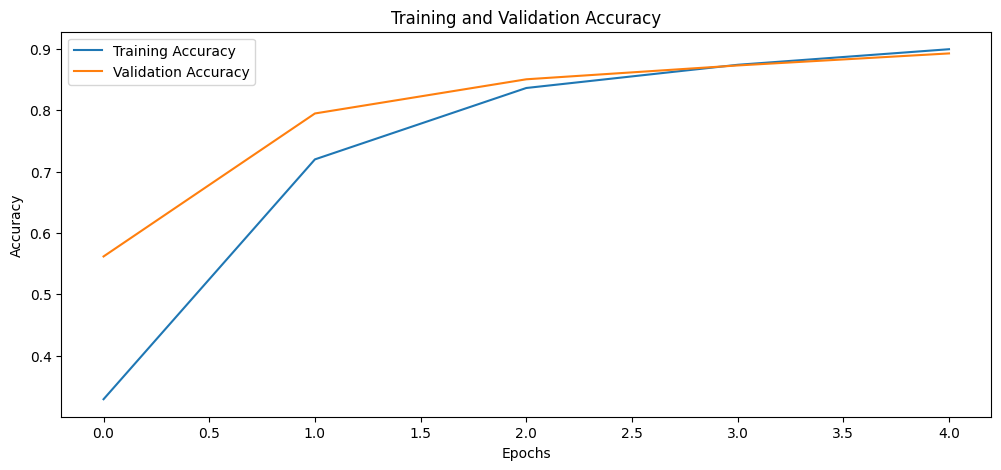

In [10]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [16]:
# Testing the Model
def test(model, test_loader):
    model.eval()
    y_true, y_scores = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    return np.array(y_true), np.array(y_scores)

y_true, y_scores = test(model, test_loader)

Test Accuracy: 0.8995


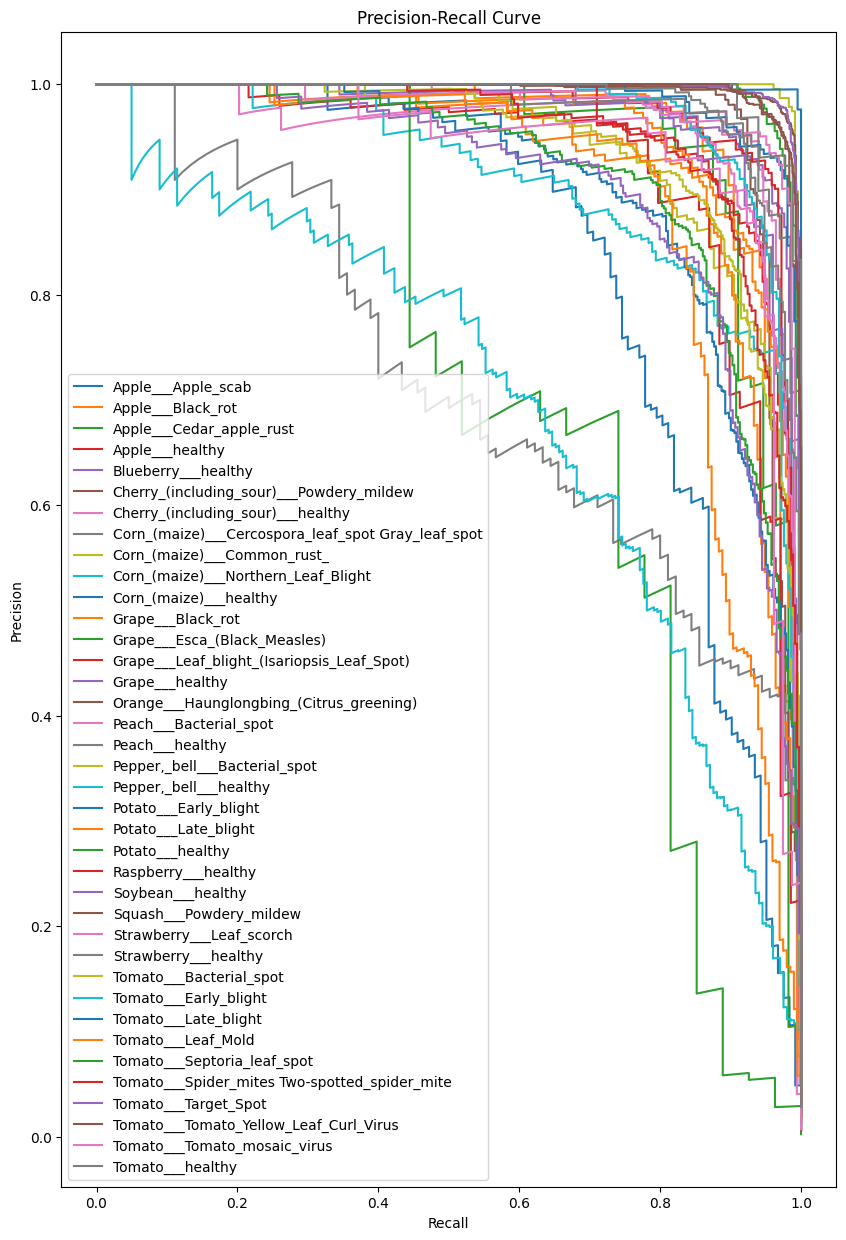

In [21]:
# Compute Precision-Recall Curve with Class Names
precision = dict()
recall = dict()
plt.figure(figsize=(10, 15))
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_scores[:, i])
    plt.plot(recall[i], precision[i], label=f'{class_names[i]}')  # Use class name

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
